In [1]:
import csv
import tweepy
import pandas as pd
import re
import string
import nltk
import time
from nltk.corpus import words
from textblob import TextBlob
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# set the path of the data set 1 (dataset which created using real time data)
df1 = pd.read_csv("Twylist Telecom Dataset.csv" ,header = None)

# 143570 data
df1.shape


(143570, 2)

In [3]:
# Name the columns
df1.columns = ['date', 'tweet']

In [4]:
words = set(nltk.corpus.words.words())

In [5]:
# words in different grammatical categories convert into one common root. 

def text_lemmatizer(text):
  # This function is used to lemmatize the given sentence
    lemmatizer =  WordNetLemmatizer ()
    token_words = word_tokenize(text)
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(lemmatizer.lemmatize(word))
    return " ".join(stem_sentence)

In [6]:
# Remove special characters from the tweet
def clean_text(tweet):
    
    tweet = tweet.lower()
    
    # have to remove "b'RT @endaburke81" at the begining of the tweet
    if(tweet[:4]=="b'rt"):
        tweet = tweet.split(":", 1)[1]

    # splitting the tweet
    tweet = tweet.split()
    
    # Joining the tweet
    tweet = " ".join(tweet)
    
    #Removing digits and numbers
    tweet = "".join([i for i in tweet if not i.isdigit()])
    
    # Removing special characters from the tweet
    tweet = re.sub(f'[{re.escape(string.punctuation)}]', "", tweet)
    
    # cleaning = nltk.tokenize.wordpunct_tokenize(tweet)
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if w.lower() in words or not w.isalpha())
    
    tweet = text_lemmatizer(tweet)
    
    return tweet

In [7]:
# adding cleaning method
df1["tweet_clean"] = df1["tweet"].apply(clean_text)

In [8]:
# sentiment analysis using polarity

df1['sentiment'] = ' '
df1['polarity'] = None
for i,tweets in enumerate(df1.tweet_clean) :
    blob = TextBlob(tweets)
    df1['polarity'][i] = blob.sentiment.polarity
    if blob.sentiment.polarity > 0 :
        df1['sentiment'][i] = 'positive'
    elif blob.sentiment.polarity < 0 :
        df1['sentiment'][i] = 'negative'
    else :
        df1['sentiment'][i] = 'neutral'
df1.head()

,date,tweet,tweet_clean,sentiment,polarity
0,2021-03-25 04:55:11,b'RT @Zahrah03959662: Parvez Abbasi- Telecom v...,abbasi veteran project director national incub...,negative,-0.0333333
1,2021-03-25 04:54:58,b'RT @Zahrah03959662: Zouhair Khaliq IT &amp; ...,it cofounder partner at team up group is a bus...,neutral,0
2,2021-03-25 04:54:31,b'RT @Shah28Adil: Zouhair is a business execut...,is a business executive with global experience...,neutral,0
3,2021-03-25 04:53:23,"b'Zouhair Khaliq IT &amp; Telecom, Co-Founder ...",it cofounder partner at team up group is a bus...,neutral,0
4,2021-03-25 04:53:12,b'Welcome! You are invited to join a webinar: ...,you are to join a editorial learning by doing g,neutral,0


In [9]:
# remove duplicate data from dataset 1
df1=df1.drop_duplicates(subset='tweet', keep="last")
df1.shape

(67359, 5)

In [10]:
# positive data count
df1.loc[df1['sentiment'] == "positive"].shape

(20867, 5)

In [11]:
# negative data count
df1.loc[df1['sentiment'] == "negative"].shape

(12002, 5)

In [12]:
# neutral data count
df1.loc[df1['sentiment'] == "neutral"].shape

(34490, 5)

In [13]:
# Remove the undefined tweets
df1 = df1.loc[df1['sentiment'] != ""]
df1

,date,tweet,tweet_clean,sentiment,polarity
1,2021-03-25 04:54:58,b'RT @Zahrah03959662: Zouhair Khaliq IT &amp; ...,it cofounder partner at team up group is a bus...,neutral,0
3,2021-03-25 04:53:23,"b'Zouhair Khaliq IT &amp; Telecom, Co-Founder ...",it cofounder partner at team up group is a bus...,neutral,0
4,2021-03-25 04:53:12,b'Welcome! You are invited to join a webinar: ...,you are to join a editorial learning by doing g,neutral,0
6,2021-03-25 04:52:59,b'Engage with your customers in real-time with...,with your in with our and measure your perform...,neutral,0
8,2021-03-25 04:52:18,b'@JioCare 1.44 mbps..??? Your 4g speed \xf0\x...,your g speed hopefully you care about the also,neutral,0
...,...,...,...,...,...
143565,2021-03-21 03:53:57,b'@enptg GOD THE FUCKING WIFI#@%*#)*%#)',god the,neutral,0
143566,2021-03-21 03:53:55,b'We don\xe2\x80\x99t accept internet shutdown...,accept shutdown we dun accept news suppression...,positive,0.5
143567,2021-03-21 03:53:55,b'nobody\xe2\x80\x99s wifi is working in the h...,is working in the house except for on my phone...,neutral,0
143568,2021-03-21 03:53:54,b'RT @KhaingEiKhaing: It\xe2\x80\x99s been 7da...,been day since the military junta cut off mobi...,positive,0.133333


In [14]:
# Remove unwanted columns to equalise two data sets
df1.drop(['date','tweet','polarity'], inplace=True, axis=1)

In [15]:
df1

,tweet_clean,sentiment
1,it cofounder partner at team up group is a bus...,neutral
3,it cofounder partner at team up group is a bus...,neutral
4,you are to join a editorial learning by doing g,neutral
6,with your in with our and measure your perform...,neutral
8,your g speed hopefully you care about the also,neutral
...,...,...
143565,god the,neutral
143566,accept shutdown we dun accept news suppression...,positive
143567,is working in the house except for on my phone...,neutral
143568,been day since the military junta cut off mobi...,positive


In [16]:
# set the path of the data set 2 
df2 = pd.read_csv("Telecom Dataset.csv" )
# Add the cleaning method
df2["tweet_clean"] = df2["text"].apply(clean_text)

In [17]:
#This data set categorize for 4 types
# Happy Customer --> Positive
# Potential New Customer --> Neutral
# Lost Customer, Poor Service --> Negative

df2['sentiment'] = ' '
for i,cat in enumerate(df2.Category) :
    if cat=='Happy Customer' :
        df2['sentiment'][i] = 'positive'
    elif cat=='Potential New Customer' :
        df2['sentiment'][i] = 'neutral'
    else :
        df2['sentiment'][i] = 'negative'
df2.head()

<ipython-input-17-75bdb9e797f2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sentiment'][i] = 'negative'
<ipython-input-17-75bdb9e797f2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sentiment'][i] = 'positive'
<ipython-input-17-75bdb9e797f2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sentiment'][i] = 'neutral'


,Unnamed: 0,Category,Label,text,tweet_clean,sentiment
0,0,Poor service,4,@VZWSupport Give me a working phone without ha...,give me a working phone without me jump throug...,negative
1,1,Poor service,4,"@verizon, my daughter and I both have #Verizon...",my daughter and i both have and we keep our fa...,negative
2,2,Poor service,4,Verizon customer service is the worst. I drea...,customer service is the worst i dread to ever ...,negative
3,3,Happy Customer,2,I love having Verizon. I get service just abou...,i love i get service just about anywhere,positive
4,4,Happy Customer,2,Great service from @VZWSupport and @SamsungSup...,great service from and tonight really quality ...,positive


In [18]:
# Remove the duplicate data
df2=df2.drop_duplicates(subset=None, keep='first', inplace=False)
df1.shape

(67359, 2)

In [19]:
# Remove unwanted columns to equalise two data sets
df2.drop(['Unnamed: 0','Category','text','Label'], inplace=True, axis=1)

In [20]:
# Merge two data sets
df = pd.concat([df1,df2])
df

,tweet_clean,sentiment
1,it cofounder partner at team up group is a bus...,neutral
3,it cofounder partner at team up group is a bus...,neutral
4,you are to join a editorial learning by doing g,neutral
6,with your in with our and measure your perform...,neutral
8,your g speed hopefully you care about the also,neutral
...,...,...
864,this is the second time the whole “ cutting se...,negative
865,a if my part of people on my bill enough a fee...,negative
866,i can call day in a row and get completely dif...,negative
867,you dont have the best network doe right,negative


In [21]:
#shuffling
df = df.sample(frac = 1)

In [22]:
#Split the data

x_train, x_test, y_train, y_test = train_test_split(df["tweet_clean"], df["sentiment"],test_size=0.2, random_state=123)

In [23]:
# Tokenize Words in each tweets (Encoding)
# TfidfVectorizer converts text to word frequency vectors

tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
tfidf_vectorizer.fit(df["tweet_clean"])
x_train_vector = tfidf_vectorizer.transform(x_train)
x_test_vector = tfidf_vectorizer.transform(x_test)

In [24]:
# Calculate accuracy, Training Time
def evaluate_metrics(y_test, y_hat, model_type,time):
    
    accuracy = accuracy_score(y_hat, y_test)
    print("Model Type : ", model_type)
    print("\nAccuracy : ", format(accuracy, '.2f'))
    print("\nTraining Time : ", format(time, '.2f'), "s" )
    print("\n", classification_report(y_hat, y_test))

    # Generate Classification Report using Heat map
    plt.figure(figsize=(10,6))
    sns.heatmap(confusion_matrix(y_hat, y_test), annot=True, fmt=".2f")
    plt.show()
    return accuracy

In [25]:
# Maximum Entropy (Logistic Regression Algorithm)

logisticR_model = LogisticRegression()
logisticR_start = time.time()
logisticR_model.fit(x_train_vector, y_train)
logisticR_stop = time.time()
logisticR_time = (logisticR_stop - logisticR_start)
logisticR_preds = logisticR_model.predict(x_test_vector)

/Users/sachinim/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Type :  Logistic Regression Classifier

Accuracy :  0.93

Training Time :  2.38 s

               precision    recall  f1-score   support

    negative       0.94      0.81      0.87      2545
     neutral       0.91      0.99      0.95      6923
    positive       0.95      0.89      0.92      4178

    accuracy                           0.93     13646
   macro avg       0.94      0.90      0.92     13646
weighted avg       0.93      0.93      0.93     13646



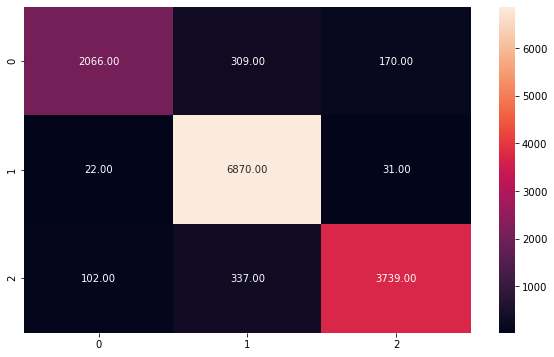

In [26]:
logisticR_accuracy = evaluate_metrics(logisticR_preds, y_test, "Logistic Regression Classifier", logisticR_time)

In [27]:
# Random Forest Algorithm

RandomForest_model = RandomForestClassifier()
RandomForest_start = time.time()
RandomForest_model.fit(x_train_vector, y_train)
RandomForest_stop = time.time()
RandomForest_time = (RandomForest_stop - RandomForest_start)
RandomForest_preds = RandomForest_model.predict(x_test_vector)

Model Type :  Random Forest Classifier

Accuracy :  0.90

Training Time :  102.66 s

               precision    recall  f1-score   support

    negative       0.94      0.74      0.83      2545
     neutral       0.88      0.99      0.93      6923
    positive       0.94      0.85      0.89      4178

    accuracy                           0.90     13646
   macro avg       0.92      0.86      0.88     13646
weighted avg       0.91      0.90      0.90     13646



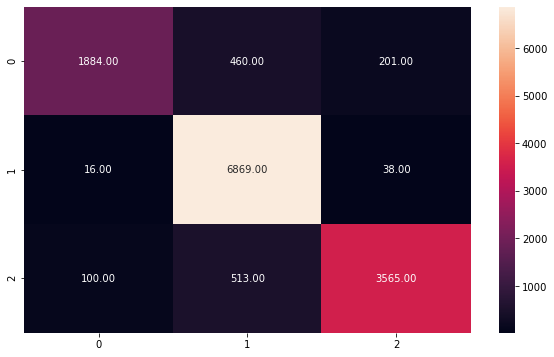

In [28]:
RandomForest_accuracy = evaluate_metrics(RandomForest_preds, y_test, "Random Forest Classifier", RandomForest_time)

In [29]:
# Decision Tree Algorithm

DecisionTree_model = DecisionTreeClassifier(max_depth=20,random_state=0)
DecisionTree_start = time.time()
DecisionTree_model.fit(x_train_vector, y_train)
DecisionTree_stop = time.time()
DecisionTree_time = (DecisionTree_stop - DecisionTree_start)
DecisionTree_pred = DecisionTree_model.predict(x_test_vector)

Model Type :  DecisionTree Classifier

Accuracy :  0.74

Training Time :  1.72 s

               precision    recall  f1-score   support

    negative       0.92      0.37      0.53      2545
     neutral       0.68      1.00      0.81      6923
    positive       0.93      0.54      0.69      4178

    accuracy                           0.74     13646
   macro avg       0.84      0.64      0.68     13646
weighted avg       0.80      0.74      0.72     13646



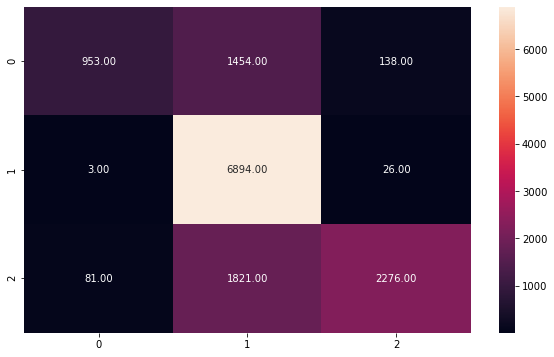

In [30]:
DecisionTree_accuracy = evaluate_metrics(DecisionTree_pred, y_test, "DecisionTree Classifier", DecisionTree_time)

In [31]:
# Support Vector Machine Algorithm (Linear SVC classifier)

svm_model = svm.SVC(kernel='linear')
svm_start = time.time()
svm_model.fit(x_train_vector, y_train)
svm_stop = time.time()
svm_time = (svm_stop - svm_start)
svm_preds = svm_model.predict(x_test_vector)

Model Type :  Support Vector Machine

Accuracy :  0.96

Training Time :  404.94 s

               precision    recall  f1-score   support

    negative       0.94      0.89      0.91      2545
     neutral       0.97      0.99      0.98      6923
    positive       0.95      0.94      0.95      4178

    accuracy                           0.96     13646
   macro avg       0.95      0.94      0.95     13646
weighted avg       0.96      0.96      0.96     13646



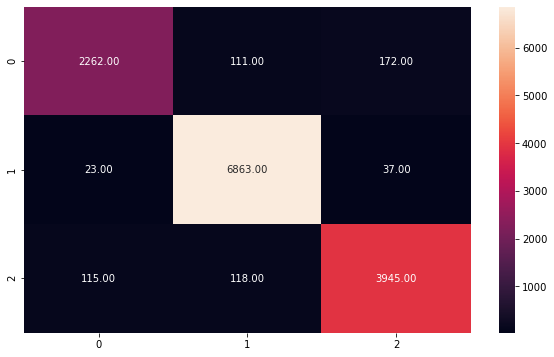

In [32]:
svm_accuracy = evaluate_metrics(svm_preds, y_test, "Support Vector Machine", svm_time)

In [33]:
# Multinomial Naive Bayes Algorithm

MultinomialNB_model = MultinomialNB()
MultinomialNB_start = time.time()
MultinomialNB_model.fit(x_train_vector, y_train)
MultinomialNB_stop = time.time()
MultinomialNB_time = (MultinomialNB_stop - MultinomialNB_start)
MultinomialNB_preds = MultinomialNB_model.predict(x_test_vector)

Model Type :  Multinomial NB Classifier

Accuracy :  0.85

Training Time :  0.14 s

               precision    recall  f1-score   support

    negative       0.90      0.64      0.75      2545
     neutral       0.83      0.98      0.90      6923
    positive       0.89      0.78      0.83      4178

    accuracy                           0.85     13646
   macro avg       0.87      0.80      0.83     13646
weighted avg       0.86      0.85      0.85     13646



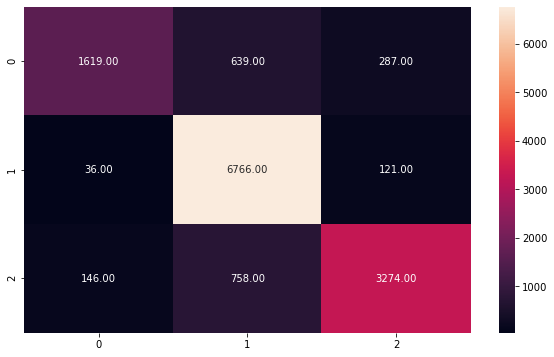

In [34]:
MultinomialNB_accuracy = evaluate_metrics(MultinomialNB_preds, y_test, "Multinomial NB Classifier", MultinomialNB_time)

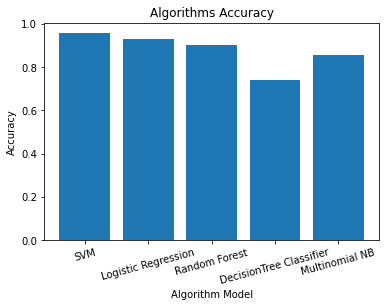

In [35]:
# Graph view of Accuracy

x = ["SVM","Logistic Regression","Random Forest", "DecisionTree Classifier", "Multinomial NB"]
y = [svm_accuracy,logisticR_accuracy,RandomForest_accuracy,DecisionTree_accuracy, MultinomialNB_accuracy]

plt.bar(x=x, height=y)
# Graph Title
plt.title("Algorithms Accuracy")
# Label of Y axis
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
#Label of X axis
plt.xlabel("Algorithm Model")

plt.show()

In [36]:
#save tfidf
with open("tfidf3.pkl", 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

In [37]:
#save model
with open("model3.pkl", 'wb') as file:
    pickle.dump(svm_model, file)

In [38]:
########### Load and get Predictions - Should goes to the backend 

with open("model3.pkl", 'rb') as file:
    model = pickle.load(file)
    
with open("tfidf3.pkl", 'rb') as file:
    tfidf = pickle.load(file)

In [39]:
# predict --> Positive
sentence = "good service"

In [40]:
token = tfidf_vectorizer.transform([sentence])

In [41]:
model.predict(token)[0]

'positive'

In [42]:
# predict --> Neutral
sentence = "service"

In [43]:
token = tfidf_vectorizer.transform([sentence])

In [44]:
model.predict(token)[0]

'neutral'

In [45]:
# predict --> Neutral
sentence = "bit"

In [46]:
token = tfidf_vectorizer.transform([sentence])

In [47]:
model.predict(token)[0]

'neutral'

In [48]:
# predict --> Positive
sentence = "good"

In [49]:
token = tfidf_vectorizer.transform([sentence])

In [50]:
model.predict(token)[0]

'positive'

In [51]:
# predict --> Negative
sentence = "worst service ever"

In [52]:
token = tfidf_vectorizer.transform([sentence])

In [53]:
model.predict(token)[0]

'negative'

In [54]:
# predict --> Neutral
sentence = "hi"

In [55]:
token = tfidf_vectorizer.transform([sentence])

In [56]:
model.predict(token)[0]

'neutral'

In [57]:
# predict --> Positive
sentence = "telecommunication gives a good super service to their customers"

In [58]:
token = tfidf_vectorizer.transform([sentence])

In [59]:
model.predict(token)[0]

'positive'